In [1]:
from verano import *
%matplotlib inline

# Load dataset and descriptor names

In [2]:
datasets=['Delaney','Test']

md_suffix=['67','PCAS','UD','PFAS','PC']

md_names=['RF & 67 Descriptors',
          'RF & PCA selected',
          'RF & Uncorrelated',
          'RF & PFA selected',
          'RF & Principal components',
          'Single decision tree']

## Load descriptor names

In [3]:
file='./data/descriptors.txt'

with open(file,'r') as lines:
    descriptors=lines.readlines()

descriptors=[x.strip() for x in descriptors] 

print('The first five descriptors are:',descriptors[:5])

The first five descriptors are: ['BalabanJ', 'BertzCT', 'HallKierAlpha', 'Ipc', 'MolLogP']


# Create standard descriptors

## Import datasets, create standard descriptors

Run this part to create the standard descriptors using the RDKit software library or go to section 1.3 to load the saved data directly

In [ ]:
cols=['name','logS','smiles']
data_up=[]

count=0
for i,dataset in enumerate(data_csv):
    print('importing dataset',dataset)
    vars()[dataset]=pd.read_csv('./data/{0}.csv'.format(dataset))
    vars()[dataset].columns=cols
    # Convert all smiles strings to canonical format
    vars()[dataset]['smiles']=canonicals(vars()[dataset].smiles)
    vars()[dataset]['data']=[i]*len(vars()[dataset])
    data_up.append(vars()[dataset])
    count+=len(vars()[dataset])

print('Number of total compounds across all sets:',count)

# create one dataframe with all solubility data
mol_data=pd.concat(data_up,ignore_index=True)

In [ ]:
# Convert to rdkit format and add hydrogens
mol_rdkit=SMILES2MOLES(mol_data.smiles)
mol_h=ADDH_MOLES(mol_rdkit)

# Get 67 standard descriptors
mol_SD,del_idx=STDD(mol_h)
mol_descriptors=pd.DataFrame(data=mol_SD)

# Delete molecules whose descriptors could not be obtained
mol_data=mol_data.drop(del_idx)
mol_data=mol_data.reset_index(drop=True)

In [ ]:
# Remove any molecules having a nan as a value
mol_data,mol_descriptors=remove_nans(mol_data,mol_descriptors)

## Save data

In [ ]:
# Save descriptors to save time 
# pkl.dump(mol_data,open('./data/pa_data.pkl','wb'))
# pkl.dump(mol_descriptors,open('./data/pa_descriptors.pkl','wb'))

## Load saved data 

In [4]:
mol_data=pkl.load(open('./data/pa_data.pkl','rb'))
mol_descriptors=pkl.load(open('./data/pa_descriptors.pkl','rb'))

## Create lists to store the indices of the training/test data

In [5]:
test_idx=list(mol_data.index[mol_data['data']==1])
train_idx=list(mol_data.index[mol_data['data']==0])

## Distribution of train/test set values

In [6]:
test_mean=mol_data.loc[test_idx].logS.values.mean()
test_std=mol_data.loc[test_idx].logS.values.std()

In [7]:
logs_values=[]
for dataset in ['train','test']:
    logs_values.append(mol_data.iloc[vars()[dataset+'_idx']].logS.values)
    print('{0}ing set has mean logS of {1}, std of {2}'.\
          format(dataset,
                 round(np.mean(logs_values[-1]),2),
                 round(np.std(logs_values[-1]),2)))

training set has mean logS of -3.05, std of 2.11
testing set has mean logS of -4.03, std of 1.27


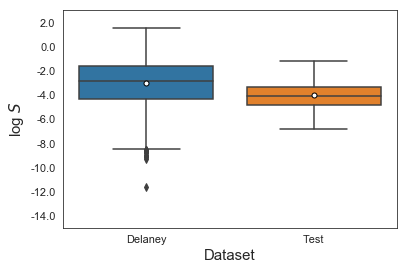

In [8]:
fs=15
plt.figure(figsize=(6,4))
plt.ylim((-15,3))
plt.ylabel('log $S$',fontsize=fs)
plt.xlabel('Dataset',fontsize=fs)
ax=sns.boxplot(data=logs_values,showmeans=True,
              meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticklabels(datasets,fontsize=fs-4)
ax.set_yticklabels(ax.get_yticks(),size=fs-4)
plt.show()

# Principal component analysis

PCA is applied on the standardized training data. The model is then used to transform the standardized test data. 

In [9]:
train_MD=mol_descriptors.iloc[train_idx]
test_MD=mol_descriptors.iloc[test_idx]

# Normalize or 'z-score' features
ss=StandardScaler()
train_scaled=ss.fit_transform(train_MD)
test_scaled=ss.transform(test_MD)

# PCA model
pca=PCA()
project_train=pca.fit_transform(train_scaled)
project_test=pca.transform(test_scaled)

## Proportion of variance explained 

Using the PCA model, we can see how many principal components (PCs) are required to have 90% of the cumulative proportion of variance explained (PVE) and the individual PVE values for those PC.

In [10]:
N_pc=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)[0][1]
print('90% variance explained by first {} PCs with each having PVE values of:'.format(N_pc))
print(pca.explained_variance_ratio_[:N_pc])

print('\nCumulative PVE of first {} PCs:'.format(N_pc))
print(np.cumsum(pca.explained_variance_ratio_)[:N_pc])

90% variance explained by first 12 PCs with each having PVE values of:
[0.409322   0.11698384 0.08332586 0.07233672 0.05429948 0.03706247
 0.03440997 0.02583688 0.02166741 0.01907178 0.01677581 0.01458164]

Cumulative PVE of first 12 PCs:
[0.409322   0.52630584 0.6096317  0.68196842 0.7362679  0.77333037
 0.80774034 0.83357722 0.85524463 0.87431641 0.89109222 0.90567386]


The PVE and cumulative PVE can be visualized using a scree plot which shows these values for the first 30 PCs. 

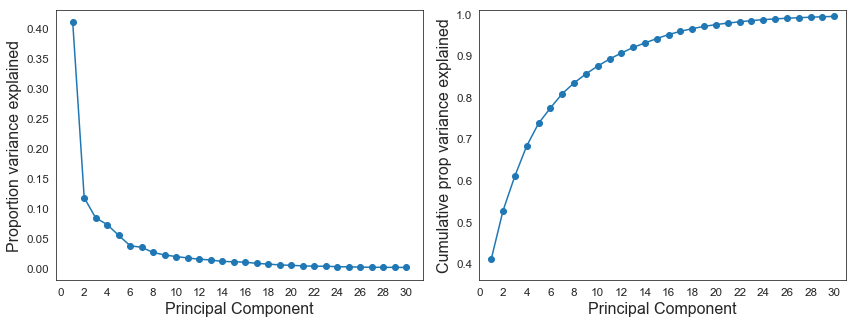

In [11]:
fs=18
N_plot=30
fig,axes=plt.subplots(1,2,figsize=(12,5))

axes[0].plot(range(1,N_plot+1),pca.explained_variance_ratio_[:N_plot],'-o')
axes[0].set_ylabel('Proportion variance explained',fontsize=fs-2)
axes[0].set_xlabel('Principal Component',fontsize=fs-2)

axes[1].plot(range(1,N_plot+1),np.cumsum(pca.explained_variance_ratio_)[:N_plot],'-o')
axes[1].set_xlim(0,N_plot+1)
axes[1].set_ylim(0.36,1.01)
axes[1].set_ylabel('Cumulative prop variance explained',fontsize=fs-2)
axes[1].set_xlabel('Principal Component',fontsize=fs-2)

for i in range(2):
    axes[i].set_xticks(np.linspace(0,N_plot,16))
    for tick in axes[i].xaxis.get_major_ticks():
        tick.label.set_fontsize(fs*0.65) 
    for tick in axes[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(fs*0.65) 
        
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

## Distribution of train/test datasets based on two principal components

We can compare how the training and test datasets are distributed using the information summarized within a pair of PCs and see how solubility relates to both via side-by-side plots. 

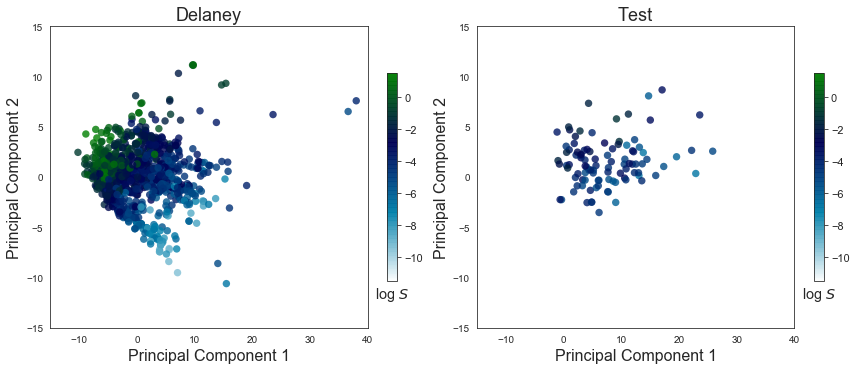

In [12]:
# Change the values of pc1 and pc2 to visualize other PCs

pc1=0
pc2=1

fs=18
mapcolor='ocean_r' 
vmin=-11.5
vmax=1.5

projections=[project_train,project_test]
fig,axes=plt.subplots(1,2,figsize=(16*0.75,7*0.75))
for i,dataset in enumerate(['train','test']):
    ax=axes[i]
    projection=projections[i]
    x=projection[:,pc1]
    y=projection[:,pc2]
    c=mol_data.logS[vars()[dataset+'_idx']]
    vars()[dataset+'plot']=ax.scatter(x,y,
                    edgecolor='none',
                    alpha=0.8,
                    c=c,
                    cmap=plt.cm.get_cmap(mapcolor),
                    s=55,vmin=vmin,vmax=vmax)
    ax.set_xlabel('Principal Component {}'.format(pc1+1),fontsize=fs-2)
    ax.set_ylabel('Principal Component {}'.format(pc2+1),fontsize=fs-2)
    cbar=plt.colorbar(vars()[dataset+'plot'],ax=ax,fraction=0.03,pad=0.055)
    cbar.ax.tick_params(labelsize=11)
    cbar.ax.set_xlabel('log $S$',fontsize=fs*0.8)
    ax.set_title('{}'.format(datasets[i]),fontsize=fs)
    ax.set_xlim(-15,40)
    ax.set_ylim(-15,15)

plt.tight_layout()
plt.show()

## Descriptor loadings for each component

The individual PCs can be analyzed to see which descriptors are weighted the most based on their absolute 'loadings' with larger absolute loadings indicating a higher influence of that descriptor for that PC. 

In [13]:
# Create a dataframe of the absolute loadings 
loadings=pd.DataFrame()
loadings_mat=abs(pca.components_)

for j in range(pca.n_components_):
    
    sorted_feats=[]
    for i in loadings_mat[j,:].argsort()[::-1]:
        sorted_feats.append((descriptors[i],loadings_mat[j,:][i]))
        
    loadings['PC'+str(j+1)]=sorted_feats

In [14]:
loadings.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67
0,"(NumValenceElectrons, 0.18856765886128865)","(MolLogP, 0.30122047685612574)","(FractionCSP3, 0.3589994048991528)","(NPR1, 0.3214508353319233)","(NPR1, 0.2804236397278949)","(FpDensityMorgan1, 0.3092211237768457)","(Asphericity, 0.2675138539753652)","(NumAliphaticHeterocycles, 0.3563655110442722)","(NumAmideBonds, 0.45874626955517506)","(NumSpiroAtoms, 0.4026300069245248)",...,"(Chi0n, 0.6788957276482404)","(ExactMolWt, 0.782824881106898)","(MolWt, 0.7193823844337691)","(NumSaturatedRings, 0.6456788992055815)","(NumAromaticRings, 0.6391336865353691)","(NumAliphaticRings, 0.5518985111888687)","(NOCount, 0.47038281284874445)","(NumAliphaticCarbocycles, 0.4416142519985528)","(NumHeterocycles, 0.623616494080705)","(NumLipinskiHBD, 0.6251634897721018)"
1,"(HeavyAtomCount, 0.18816331721046975)","(TPSA, 0.2561931393865161)","(NumAromaticRings, 0.3163125025856522)","(Eccentricity, 0.29691920221869184)","(NumAliphaticCarbocycles, 0.27132152170932833)","(FpDensityMorgan2, 0.30569776746139565)","(HallKierAlpha, 0.26028830746812714)","(NumHeterocycles, 0.32393261481345376)","(NumAromaticHeterocycles, 0.40016264820423536)","(InertialShapeFactor, 0.39887224569884916)",...,"(Chi1n, 0.636657528300019)","(HeavyAtomMolWt, 0.3990171868318757)","(HeavyAtomMolWt, 0.6905682922167341)","(NumSaturatedCarbocycles, 0.5479938826723059)","(RingCount, 0.5811335066226403)","(NumAromaticCarbocycles, 0.5003668960016543)","(NumLipinskiHBA, 0.4703828128487443)","(NumAromaticCarbocycles, 0.4267955932307016)","(NumAliphaticHeterocycles, 0.4918583692620539)","(NHOHCount, 0.6251634897721017)"
2,"(LabuteASA, 0.186746711502427)","(NumLipinskiHBA, 0.242414538102865)","(SpherocityIndex, 0.26243566560873394)","(Asphericity, 0.29674980123098915)","(Asphericity, 0.26937521469005266)","(FpDensityMorgan3, 0.29352125960006004)","(NumAromaticHeterocycles, 0.2528280000091574)","(NumSaturatedHeterocycles, 0.2939491170493602)","(NumHeterocycles, 0.3118098492351763)","(SpherocityIndex, 0.266849518088368)",...,"(ExactMolWt, 0.20681556844159274)","(MolWt, 0.3924212142898523)","(Chi0n, 0.06740283569956598)","(NumSaturatedHeterocycles, 0.2856878256211705)","(NumAliphaticRings, 0.21604475565078826)","(NumAromaticRings, 0.30199918975744544)","(NumAliphaticRings, 0.4087910287507721)","(RingCount, 0.3906360565447008)","(NumAromaticHeterocycles, 0.48666858510511696)","(NumLipinskiHBA, 0.3284607493183505)"
3,"(MolMR, 0.1828091826440864)","(NOCount, 0.24241453810286498)","(NumAromaticCarbocycles, 0.249726376022576)","(Kappa2, 0.24349633483773286)","(NumSaturatedCarbocycles, 0.262489501009838)","(NumSaturatedHeterocycles, 0.25568478792577753)","(NPR1, 0.23995992986295503)","(InertialShapeFactor, 0.2806687695701257)","(MaxPartialCharge, 0.2709067103071554)","(NumAmideBonds, 0.2384660135419629)",...,"(Chi1, 0.17209358487574808)","(Chi0n, 0.18740992612139373)","(HeavyAtomCount, 0.03056855421211107)","(NumAliphaticRings, 0.21925816522169578)","(NumAliphaticCarbocycles, 0.2083003547770353)","(RingCount, 0.30196501607703763)","(NumAliphaticCarbocycles, 0.3513117897207779)","(NumHeterocycles, 0.3514983056312566)","(RingCount, 0.2287103247590162)","(NOCount, 0.32846074931835045)"
4,"(Chi2n, 0.18223068516128066)","(NumHDonors, 0.23861867029184977)","(HallKierAlpha, 0.24125674601506641)","(NumBridgeheadAtoms, 0.23661379163557547)","(Eccentricity, 0.24399565842501675)","(NumHeteroatoms, 0.2102238258276465)","(NHOHCount, 0.20894130467008537)","(NumLipinskiHBD, 0.2580622861017464)","(NumSpiroAtoms, 0.26912819432887786)","(NHOHCount, 0.23630411948295782)",...,"(HeavyAtomCount, 0.16380600173559143)","(Chi1n, 0.15759651086429396)","(NumValenceElectrons, 0.009714182657973375)","(NumAromaticRings, 0.19464372967671115)","(NumAromaticCarbocycles, 0.18059229905503849)","(NumAliphaticCarbocycles, 0.27280231901080504)","(NumSaturatedRings, 0.23857056023664067)","(NumLipinskiHBA, 0.3212518991949781)","(NumSaturatedRin

To determine how each of the descriptors relate to one another, we can use the loading values from a pair of PCs to create feature vectors that are visualized in a biplot. 

In [15]:
# Create a dataframe of the loadings (but without absolute value)
loadings=pd.DataFrame()
loadings_mat=pca.components_

for j in range(pca.n_components_):
    
    sorted_feats=[]
    for i in loadings_mat[j,:].argsort()[::-1]:
        sorted_feats.append((descriptors[i],loadings_mat[j,:][i]))
        
    loadings['PC'+str(j+1)]=sorted_feats

In [16]:
# Get loadings for individual descriptors to create biplot
pc1_idx=[]
pc2_idx=[]

for i in range(67):
    pc1_idx.append(loadings['PC1'][i][0])
    pc2_idx.append(loadings['PC2'][i][0])

In [17]:
# Create the vector of loadings for four descriptors in v1
# Normalize each vector in v2
v1=[]
v2=[]

# Can change these descriptor names to look at other ones
desctype=['MolWt','MolMR','MolLogP','TPSA']

for i in desctype:
    idx1=pc1_idx.index(i)
    idx2=pc2_idx.index(i)
    v1.append([loadings['PC1'][idx1][1],loadings['PC2'][idx2][1]])
    v2.append(v1[-1]/np.linalg.norm(v1[-1]))

In [18]:
for i in range(len(desctype)):
    print('The feature and normalized feature vectors for {}\n'.
          format(desctype[i]),v1[i],v2[i])

The feature and normalized feature vectors for MolWt
 [0.17893943950509988, -0.052926499794896845] [ 0.95893316 -0.28363214]
The feature and normalized feature vectors for MolMR
 [0.1828091826440864, -0.0754746690967199] [ 0.92432113 -0.38161558]
The feature and normalized feature vectors for MolLogP
 [0.06543176115805881, -0.30122047685612574] [ 0.21227181 -0.97721066]
The feature and normalized feature vectors for TPSA
 [0.11267135835374087, 0.2561931393865161] [0.40257809 0.91538565]


The dot product between two normalized feature vectors is indicative of their relationship:

1. 0: descriptors are independent
2. -1: linearly negatively correlated
3. 1: linearly positively correlated

For MolMR and MolWt, we see that they are very positively correlated. 

In [19]:
print(np.dot(v2[0],v2[1]))

0.9946006266116814


These vectors can be analyzed on a biplot and we can also see how the first two PCs compare to different descriptors in side-by-side plots.

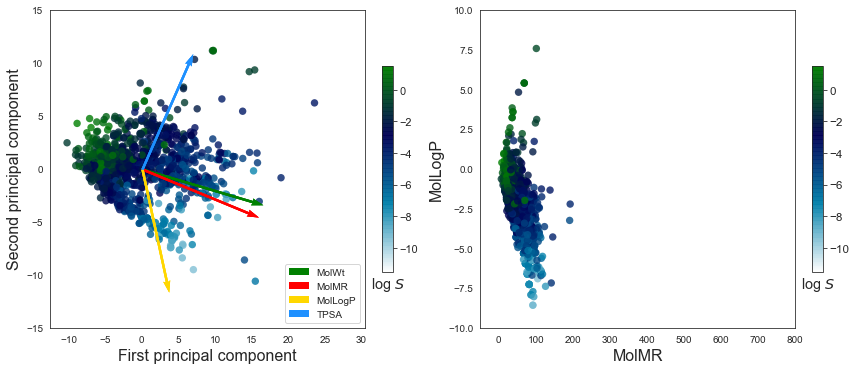

In [39]:
# Plot of lipophilicity against exact molecular weight
plot_idx=train_idx
feature_idx1=5
feature_idx2=4
s1=1
s2=-1
pc1=0
pc2=1

fs=18
fig,axes=plt.subplots(1,2,figsize=(16*0.75,7*0.75))
ax=axes[0]
x=project_train[:,pc1]
y=project_train[:,pc2]
c=mol_data.logS[plot_idx]
del_plot=ax.scatter(x,y,
                edgecolor='none',
                alpha=0.8,
                c=c,
                cmap=plt.cm.get_cmap(mapcolor),
                s=55,vmin=vmin,vmax=vmax)
ax.set_xlabel('First Principal Component',fontsize=fs-2)
ax.set_ylabel('Second Principal Component',fontsize=fs-2)
cbar=plt.colorbar(del_plot,ax=ax,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_xlabel('log $S$',fontsize=fs*0.8)
ax.set_xlim(-12.5,30.5)
ax.set_ylim(-15,15)


V=np.array(v2)
c=['green','red','gold','dodgerblue']
origin=np.array([[0,0,0],[0,0,0]])
for i in range(4):
    ax.quiver(*origin,V[i,0],V[i,1],color=c[i],scale=2.5,label=desctype[i])
ax.set_xlabel('First principal component',fontsize=fs-2)
ax.set_ylabel('Second principal component',fontsize=fs-2)
ax.legend(loc=4)

featplot=axes[1].scatter(s1*mol_descriptors.iloc[plot_idx][feature_idx1],
                s2*mol_descriptors.iloc[plot_idx][feature_idx2],
            edgecolor='none',
            alpha=0.8,
            c=mol_data.iloc[plot_idx]['logS'],
            s=55,
            cmap=plt.cm.get_cmap(mapcolor),vmin=vmin,vmax=vmax) #,6))
axes[1].set_ylabel(descriptors[feature_idx2],fontsize=fs-2)
axes[1].set_xlabel(descriptors[feature_idx1],fontsize=fs-2)
cbar=plt.colorbar(featplot,fraction=0.03,pad=0.05,ax=axes[1])
cbar.ax.tick_params(labelsize=0.65*fs)
cbar.ax.set_xlabel('log $S$',fontsize=fs*0.8)
axes[1].set_xlim(-50,800)
axes[1].set_ylim(-10,10)

plt.tight_layout()
plt.show()

# Correlation analysis on Delaney dataset

Looking at the Pearson correlation coefficient (PCC) between pairs of descriptors presents another way to do dimensionality reduction. Here the heatmap shows the PCC between pairs of descriptors.

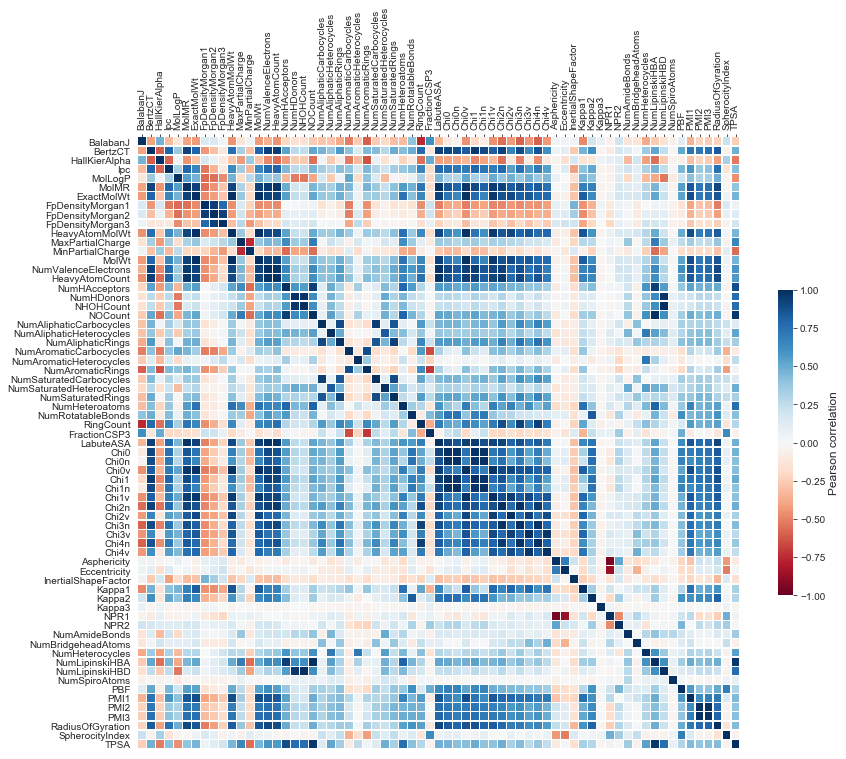

In [21]:
md_Delaney=mol_descriptors.iloc[train_idx]
corr_mat=md_Delaney.corr()
corr_mat.columns=descriptors

plt.figure(figsize=(9*1.5,7.5*1.5),facecolor='w',edgecolor='k')
ax=sns.heatmap(corr_mat,linewidth=0.25,cmap='RdBu',
               cbar_kws={'shrink': 0.5,'label':'Pearson correlation'},
               xticklabels=corr_mat.columns,yticklabels=corr_mat.columns,
              vmin=-1,vmax=1)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation='vertical')
plt.show()

## Find features with correlations greater than 0.80

We can find features that have absolute PCC greater than 0.80. 

In [22]:
threshold=0.8

corr_np=np.array(abs(corr_mat))
np.fill_diagonal(corr_np,0)

# Where in the correlation matrix are values above threshold
corr_80=corr_np>=threshold

# List of the sets of correlated features
merge_corr=[]

for i in range(67):
    corrs=[]
    column=corr_80[:,i]
    if np.max(column)==1:
        corrs.append((descriptors[i],i))
        feats=np.where(column==1)
        for f in feats[0]:
            corrs.append((descriptors[f],f,corr_np[i,f]))
        merge_corr.append(corrs)

In [23]:
indices=set()

for sets in merge_corr:
    for i,s in enumerate(sets):
        if i==0:
            print('Correlations for feature: ',s)
        else:
            print(s)
        indices.add(s[1])
    print('\n')
    
indices=list(indices)

print('Number of features correlated with Pearson coeff >= {0}: {1}'.format(threshold,len(indices)))

Correlations for feature:  ('BertzCT', 1)
('Ipc', 3, 0.8020795186020098)
('MolMR', 5, 0.9277880203272549)
('NumValenceElectrons', 14, 0.9347729399567096)
('HeavyAtomCount', 15, 0.9488765970103739)
('LabuteASA', 33, 0.935961774929894)
('Chi0', 34, 0.9124950275188675)
('Chi0n', 35, 0.8842104342740619)
('Chi0v', 36, 0.8351973624898567)
('Chi1', 37, 0.9544528711902163)
('Chi1n', 38, 0.9034507338987737)
('Chi1v', 39, 0.8203475181820845)
('Chi2n', 40, 0.9360952570425749)
('Chi3n', 42, 0.8975460073062719)
('Chi4n', 44, 0.8606544686651534)
('RadiusOfGyration', 64, 0.8437285540512478)


Correlations for feature:  ('Ipc', 3)
('BertzCT', 1, 0.8020795186020098)
('HeavyAtomCount', 15, 0.8098729986154406)


Correlations for feature:  ('MolMR', 5)
('BertzCT', 1, 0.9277880203272549)
('ExactMolWt', 6, 0.9359909818603593)
('HeavyAtomMolWt', 10, 0.9168889797676456)
('MolWt', 13, 0.9346242380941521)
('NumValenceElectrons', 14, 0.9599237015263649)
('HeavyAtomCount', 15, 0.9702258809394846)
('LabuteASA', 33

As many of the descriptors are highly correlated with another, we can remove those descriptors that have the greatest average PCC with all the rest until there is no longer between-descriptor PCC values greater than 0.80.

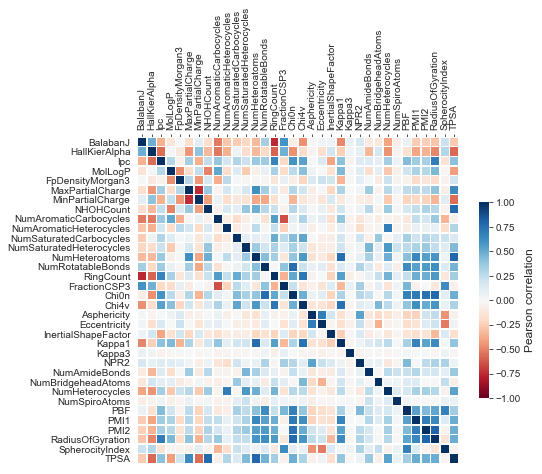

In [24]:
Delaney_UD=uncorr_descriptor(mol_descriptors,train_idx,test_idx)
corr_mat=Delaney_UD.corr()
descriptors_uncorr=[descriptors[int(i)] for i in Delaney_UD.keys()]
corr_mat.columns=descriptors_uncorr

plt.figure(figsize=(9*0.8,7.5*0.8),facecolor='w',edgecolor='k')
ax=sns.heatmap(corr_mat,linewidth=0.5,cmap='RdBu',
               xticklabels=corr_mat.columns,yticklabels=corr_mat.columns,
               cbar_kws={'label':'Pearson correlation','shrink':0.6},
               vmin=-1,vmax=1)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation='vertical')
plt.show()

# Prediction models using random forests

## Cross validation

The PCA and correlation analysis can be utilized to do dimensionality reduction and feature selection. Four subsets and versions of the original descriptors are created from that analysis:

1. Principal components representing 90% of the cumulative PVE
2. A subset of descriptors chosen based on their loadings for PCs representing 80% of the cumulative PVE
3. Principal feature selection based on the number of PCs representing 90% of the cumulative PVE 
4. Correlation analysis from section 3.1 

5-Fold cross-validation will be used to determine which of those four along with the full 67 descriptors will be effective. 

In [25]:
# Dictionary to store results
cv_results={}

# Defining splits for cross validation
kf=KFold(n_splits=5,random_state=44,shuffle=True)
X=mol_descriptors.iloc[train_idx]
Y=mol_data.iloc[train_idx]

for j,dtype in enumerate(md_suffix):
    print('Cross validation on {}'.format(md_names[j]))
    
    for i,[train_index,test_index] in enumerate(kf.split(X,Y)):

        train_index=list(train_index)
        test_index=list(test_index)
        
        X_desc=get_descriptor(dtype,X,train_index,test_index)
        Xtrain_kf=X_desc.loc[train_index]
        Xtest_kf=X_desc.loc[test_index]
        Ytrain_kf=mol_data.iloc[train_index]['logS'].values
        Ytest_kf=mol_data.iloc[test_index]['logS'].values
        scaler=StandardScaler()
        Ytrain_ss=scaler.fit_transform(np.array(Ytrain_kf).reshape(-1,1))
        
        rf=RandomForestRegressor(n_estimators=500,random_state=10)
        rf.fit(Xtrain_kf,np.ravel(Ytrain_ss))
        yhat_kf=scaler.inverse_transform(rf.predict(Xtest_kf))
        cv_results[dtype+str(i)]=[Ytest_kf,yhat_kf]
        print('Completed fold',i)

Cross validation on RF & 67 Descriptors
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4
Cross validation on RF & PCA selected
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4
Cross validation on RF & Uncorrelated
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4
Cross validation on RF & PFA selected
Completed fold 0
Completed fold 1
Completed fold 2


/home/chem/phrfqd/Untitled Folder/verano.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  A_q=egnvecs[:,:q].astype(float)


Completed fold 3
Completed fold 4
Cross validation on RF & Principal components
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


### Cross-validation results

Consolidate cross-validation the mean results of each fold into a dataframe. Results are evaluated based on two metrics:

1. RMSE
2. Percent accuracy based on number of predictions being within $\pm$ of 0.7 log$S$ units 

In [26]:
cv_columns=['Descriptor','RMSE','RMSE/SD','logS_pm0.7']
cv_metrics=pd.DataFrame(columns=cv_columns)
     
for i,dtype in enumerate(md_suffix):
    kf_RMSE=[]
    kf_RMSE_std=[]
    kf_logS_pm7=[]

    r_idx=5*i+j
    row=[md_names[i]]

    for k in range(5):
        Ytest_kf=cv_results[dtype+str(k)][0]
        yhat_kf=cv_results[dtype+str(k)][1]
        diff=abs(Ytest_kf-yhat_kf)
        lt7=np.sum(diff<=0.7)/len(Ytest_kf)*100

        kf_RMSE.append(np.sqrt(mse(Ytest_kf,yhat_kf)))
        kf_RMSE_std.append(kf_RMSE[-1]/np.std(Ytest_kf))
        kf_logS_pm7.append(lt7)

    row.append(np.mean(kf_RMSE))
    row.append(np.mean(kf_RMSE_std))
    row.append(np.mean(kf_logS_pm7))
    cv_metrics.loc[r_idx]=row

In [27]:
cv_metrics.sort_values('RMSE')

,Descriptor,RMSE,RMSE/SD,logS_pm0.7
14,RF & Uncorrelated,0.651791,0.310594,77.946429
4,RF & 67 Descriptors,0.656611,0.313246,78.392857
9,RF & PCA selected,0.667013,0.317953,78.392857
19,RF & PFA selected,0.772458,0.367793,72.589286
24,RF & Principal components,0.821045,0.390951,68.482143


## Random forest models

Having determine which of the descriptors are the most suitable, we can choose the best ones for predicting on the test set. Since we're only dealing with one algorithm and one training dataset here, we can quickly run the RF model on all five.

In [28]:
# dictionary to store results
rf_results={}

for i,dtype in enumerate(md_suffix):
    print('Fitting RF for {}'.format(md_names[i]))
    vars()['Delaney_'+dtype]=get_descriptor(dtype,mol_descriptors,train_idx,test_idx)
    Xtrain=vars()['Delaney_'+dtype].iloc[train_idx]
    Ytrain=mol_data['logS'].iloc[train_idx]
    Xtest=vars()['Delaney_'+dtype].iloc[test_idx]
    Ytest=mol_data['logS'].iloc[test_idx]
    rf_results['Delaney_'+dtype]=rf_model(Xtrain,Xtest,Ytrain,Ytest,trees=500)

Fitting RF for RF & 67 Descriptors
Fitting RF for RF & PCA selected
Fitting RF for RF & Uncorrelated
Fitting RF for RF & PFA selected
Fitting RF for RF & Principal components


For purposes of comparison, we train a single decision tree model to make predictions and see how much predictive accuracy is gained from using an ensemble-based method such as RFs.

In [29]:
# Train a single tree using 67 descriptors for comparison
Xtrain=Delaney_67.iloc[train_idx]
Ytrain=mol_data['logS'].iloc[train_idx]
Xtest=Delaney_67.iloc[test_idx]
Ytest=mol_data['logS'].iloc[test_idx]
Delaney_tree=dtree_model(Xtrain,Xtest,Ytrain,Ytest)

### Model results

Consolidate RF results and the single decision tree performance into a dataframe.

In [30]:
rf_columns=['Descriptor','Length','RMSE','RMSE/SD','logS_pm0.7']
rf_metrics=pd.DataFrame(columns=rf_columns)
yhats=[]

for i,dtype in enumerate(md_suffix):
    
    yhats.append(rf_results['Delaney_'+dtype][0])
    diff=abs(yhats[-1]-np.array(Ytest))
    row=[md_names[i],
         vars()['Delaney_'+dtype].shape[1],
         np.sqrt(mse(yhats[-1],Ytest))]
    row.append(row[-1]/test_std)
    row.append(np.sum(diff<=0.7)/len(Ytest)*100)
    rf_metrics.loc[i]=row
    
    
yhats.append(Delaney_tree[0])
diff=abs(yhats[-1]-np.array(Ytest))
row=[md_names[5],
     Delaney_67.shape[1],
     np.sqrt(mse(yhats[-1],Ytest))]
row.append(row[-1]/test_std)
row.append(np.sum(diff<=0.7)/len(Ytest)*100)
rf_metrics.loc[5]=row

In [31]:
rf_metrics.sort_values('RMSE')

,Descriptor,Length,RMSE,RMSE/SD,logS_pm0.7
1,RF & PCA selected,29,0.928849,0.733758,61.0
2,RF & Uncorrelated,34,0.934261,0.738032,61.0
0,RF & 67 Descriptors,67,0.941912,0.744077,65.0
3,RF & PFA selected,14,1.097553,0.867028,52.0
4,RF & Principal components,7,1.145834,0.905168,53.0
5,Single decision tree,67,1.237501,0.977581,54.0


## Plot of model predictions

The results of each model are plotted to see how accurate each descriptor/model performed.

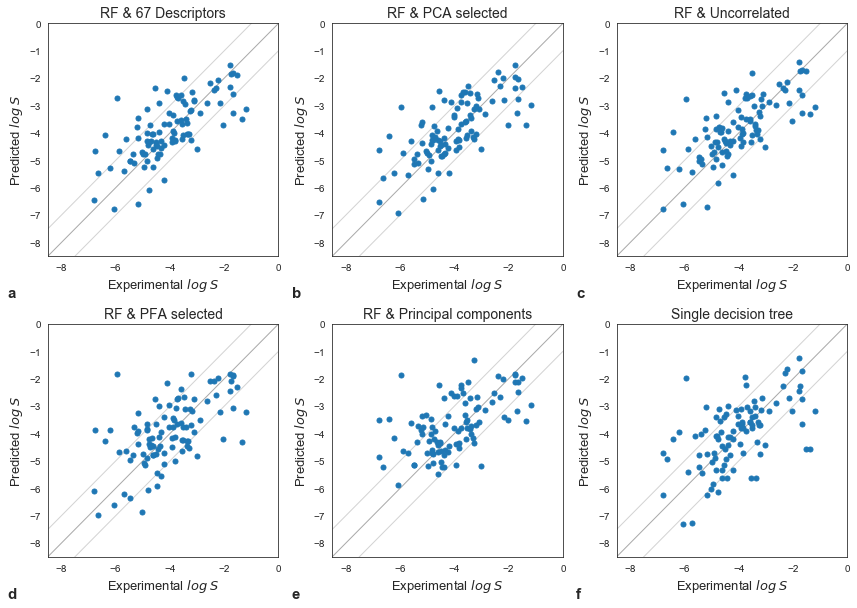

In [32]:
fs=14
lb=-8.5
ub=0

axlabels=['a','b','c','d','e','f']
color='tab:blue'
ms=25

cols=3
rows=2

fig,axes=plt.subplots(nrows=rows,ncols=cols,figsize=(12,8.5))
for i in range(6):
    ax=axes[int(i/cols)][i%cols]
    ax.scatter(Ytest,yhats[i],
               s=ms,
               color=color,
               facecolors=color)     
    resultsplot_setup(ax,fs,lb,ub,md_names[i],axlabels[i],weight='bold')

fig.tight_layout()
plt.show()

# Hard to predict molecules

In [33]:
errors=[]
for i in range(5):
    errors.append(abs(yhats[i]-Ytest))
    
errors=np.array(errors)
MAE=errors.mean(axis=0)

sort_idx=np.argsort(MAE)[::-1]
err_idx=np.array(test_idx)[sort_idx]

In [34]:
data_test=mol_data.iloc[test_idx].copy()
data_test['MAE']=MAE
data_test.sort_values('MAE',ascending=False).head(15)

,name,logS,smiles,data,MAE
1167,Folic Acid,-5.96,Nc1nc(=O)c2nc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(...,1,3.513962
1144,Cisapride,-6.78,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)C...,1,2.514765
1208,Sulfasalazine,-6.41,O=C(O)C1=C/C(=N\Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)...,1,2.436400
1158,Enalapril,-1.36,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...,1,2.307507
1134,Carbendazim,-4.56,COC(=O)Nc1nc2ccccc2[nH]1,1,2.089130
1138,Cephradine,-1.18,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)C3=CC...,1,1.880408
1133,Carbazole,-5.19,c1ccc2c(c1)[nH]c1ccccc12,1,1.765801
1155,Diltiazem,-3.02,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1,1.723677
1188,Ofloxacin,-2.03,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,1.707253
1217,Triamterene,-4.11,Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1,1,1.616929


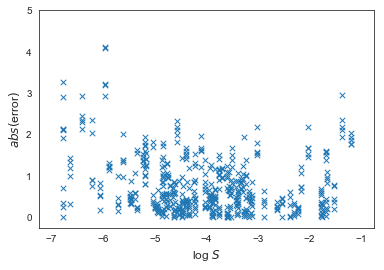

In [35]:
plt.figure(figsize=(6,4))

for i in range(5):
    plt.scatter(Ytest,errors[i],s=30,color='tab:blue',marker='x',lw=1)

plt.ylim(-0.25,5)
plt.xlim(-7.25,-0.75)
plt.xlabel('log $S$',fontsize=fs-2)
plt.ylabel('$abs($error$)$',fontsize=fs-2)
plt.setp(ax.get_xticklabels(),fontsize=fs-4)
plt.setp(ax.get_yticklabels(),fontsize=fs-4)
plt.show()

# Uncertainty quantification

Since RFs utilize a collection of decision trees, the predictions for the individual trees can be utilized to calculate an uncertainty value regarding each prediction called the 'bootstrap variance'. The variance and standard deviation for each set of predictions are calculated. Based on the standard deviation and assuming normality, a 95% prediction interval can be calculated and visualized to see how reliable is each prediction.

In [36]:
model=rf_results['Delaney_PCAS'][1]
yhat_trees=np.zeros((500,100))

for i,tree in enumerate(model.estimators_):
    yhat_trees[i,:]=tree.predict(Delaney_PCAS.iloc[test_idx])

yh_var=yhat_trees.std(axis=0)
yh_std=yhat_trees.std(axis=0)

In [37]:
# Calculate intervals  
percent=95
left=[]
right=[]
interval=np.zeros((100,3))
interval[:,0]=rf_results['Delaney_UD'][0]
for i in range(len(Ytest)):
    interval[i,1]=interval[i,0]-yh_std[i]*1.96
    interval[i,2]=interval[i,0]+yh_std[i]*1.96
    
pred_interval=pd.DataFrame(data=interval,
                           columns=['logS','lower','upper'])

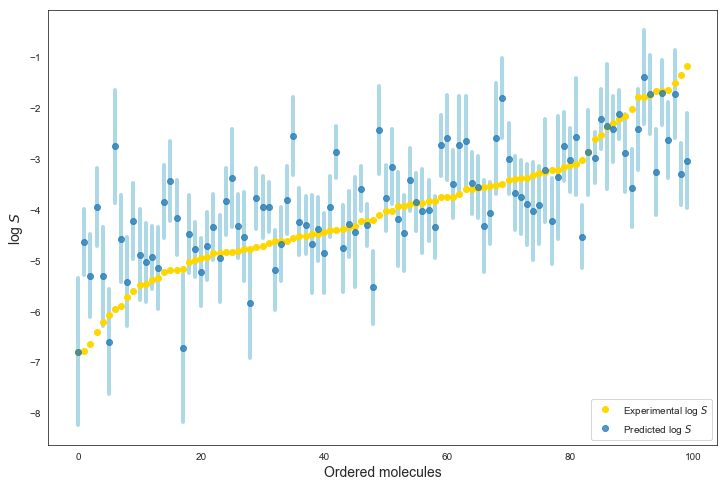

In [38]:
Y_sort=np.sort(Ytest)
Y_sort_idx=np.array(np.argsort(Ytest))
X=range(100)

plt.figure(figsize=(12,8))
plt.plot(X,Y_sort,'o',color='gold',label='Experimental log $S$')
plt.plot(X,interval[:,0][Y_sort_idx],'o',color='tab:blue',
         label='Predicted log $S$',alpha=0.75)
for i in range(100):
    lbnd=interval[Y_sort_idx[i],1]
    ubnd=interval[Y_sort_idx[i],2]
    plt.plot(X[i]*np.ones(20),np.linspace(lbnd,ubnd,20),color='lightblue',lw=4,zorder=0)
plt.legend(loc=4)
plt.ylabel('log $S$',fontsize=14)
plt.xlabel('Ordered molecules',fontsize=14)
plt.show()